## Class 10 - Image encoding and classification using CNNs and ViTs
In this class, we will use pretrained CNN and transformer models to encode and classify images.
We will use a library you are familiar with, namely Hugging Face's _transformers_, as well as (under the hood) _timm_ (another HuggingFace library, specific to computer vision) and _pytorch_.

### Instructions
**Overall goal**: training a simple fully-connected neural network that classifies snack types from this dataset (https://huggingface.co/datasets/Matthijs/snacks) based on image embeddings extracted from a pretrained ResNet model (https://arxiv.org/abs/1512.03385)

**Suggestion**: use `example.ipynb` notebook if you are in doubt! This might be especially helpful with respect to Pytorch. All we will use Pytorch for, here, are things we already did as part of NLP, but if you have not used Pytorch since it is perfectly understandable that you need a reminder.

Steps:
1. Use Hugging Face's `dataset` library to import the dataset: https://huggingface.co/datasets/Matthijs/snacks. Import the training and the test splits from this dataset, and visualize the frequency of each class.
2. Load a pretrained ResNet model using HuggingFace's `transformers`. Check the documentation (https://huggingface.co/docs/transformers/en/model_doc/resnet, https://huggingface.co/microsoft/resnet-50) for more details on how to load the model. Visualize the structure of the model, and reflect on how each of the blocks works, based on what we discussed in the lecture;
3. Extract ResNet embeddings for all the images in the training set and all the images in the test set. You will need to look for the `pooler_output` attribute of the model's output. This sounds complex, but it's really just a minor change over the examples presented in the model's documentation;
4. Optional: apply dimensionality reduction to the embeddings using TSNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): is any information about the labels encoded in the embeddings?
5. Train a simple neural network that, for each image in the training set, takes the embeddings as inputs and predicts the snack label
    - You will have to create a Pytorch `Dataset` (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) where both your embeddings and your labels are included.
    - You will also have to create a `Dataloader` for the training set, as this will make it much easier to do things like batching and shuffling
    - You need to specify the loss and the optimizer
    - Then, you need to specify a training loop. Remember the neural net gymnastics:
        - Do the forward step, i.e., make a prediction
        - Compute the loss based on predictions and true labels 
        - Compute gradients
        - Propagate gradients (backpropagation)
6. Evaluate the resulting model:
    - Make predictions for all examples in the test set
    - Use `sklearn.metrics` utils (https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) to compute accuracy and F1-score
    - Also plot the confusion matrix, to see which categories are most often confused
7. Explore zero-shot classification for computer vision
    - Try classification on custom labels on one of the images from today's dataset. To do so, adapt the code provided here: https://huggingface.co/docs/transformers/en/tasks/zero_shot_image_classification, by simply replacing the desired labels and the input
    - Can you get reasonable predictions on more nuanced labels than the ones provided with the dataset?
    - Which kind of models support this behavior? Why?

In [46]:
# label dictionary: inferred from the dataset's online documentation
label_dict = {0: 'apple',
              1: 'banana',
              2: 'cake',
              3: 'candy',
              4: 'carrot',
              5: 'cookie',
              6: 'doughnut',
              7: 'grape',
              8: 'hotdog',
              9: 'icecream',
              10: 'juice',
              11: 'muffin',
              12: 'orange',
              13: 'pineapple',
              14: 'popcorn',
              15: 'pretzel',
              16: 'salad',
              17: 'strawberry',
              18: 'waffle',
              19: 'watermelon'}

In [47]:
# Do stuff

In [48]:
from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetModel
from torchview import draw_graph
import torch

## 1 Load Data 

In [49]:
ds_train, ds_test = load_dataset("Matthijs/snacks", split=["train","test"])

## 2 Load ResNet

In [50]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [51]:
model

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

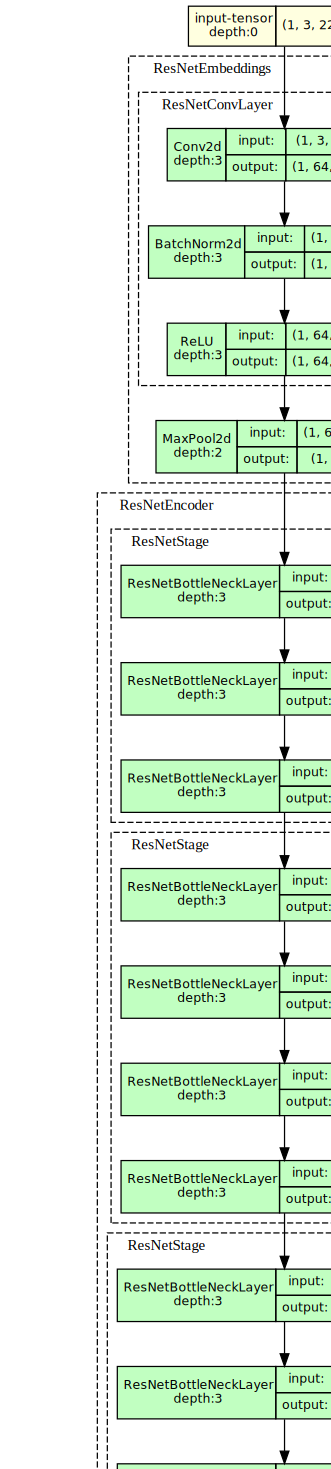

In [52]:
draw_graph(model, input_size=(1,3,224,224), expand_nested=True).visual_graph 

## 3 Extract Embeddings

In [53]:
# extracting the embeddings for all images in the dataset (func)
def get_embeddings(dataset, output):
    for i, image in enumerate(dataset['image']):
        inputs = image_processor(image, return_tensors="pt")


        with torch.no_grad():
            outputs = model(**inputs)

        embedding = outputs.pooler_output
        output.append(embedding.squeeze())
    return torch.stack(tuple(output))

In [54]:
embeddings_train = []
embeddings_test = []

train_embeddings = get_embeddings(ds_train, embeddings_train)
test_embeddings = get_embeddings(ds_test, embeddings_test)

## 5 Train a simple model

#### Bonus CV tasks
- Try training a classifier on embeddings extracted from a vision transformer: how does performance compare to ResNet?
- Build a CNN from scratch for this classification task: how does performance compare? There are lots of tutorials online, you can start from this one: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.
- Look up models and pipelines for more computer vision tasks, including semantic segmentation, object detection (which can also be performed zero-shot using ViT), etc.

#### Bonus NN-related tasks
- Train NN-based models (FFNNs or RNNs) on the bike data: how does performance compare to the best algorithms?

### Additional tasks
- A wide array of pretrained models for audio classification (including zero-shot audio classification) are also available on Hugging Face. Experiment with those :)

### Additional notes
- Here, we worked with pretrained models. If you want to train a CNN from scratch (e.g., because you are working with "special" image data, and no pretrained models are available), you can look up, for example, _Pytorch_'s intro tutorial (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). There are really a billion resources online if this is what you decide to focus on for your final project;
- If, instead, fine-tuning a full model is what you want to do, plenty of tutorials are available for tasks ranging from image classification, object detection, image segmentation, etc. Look up _timm_'s documentation (https://huggingface.co/docs/hub/en/timm) and _transformers_'s documentation (https://huggingface.co/docs/transformers/tasks/image_classification).